# Segmenting and Clustering Neighborhoods in Toronto Project

## Introduction

This project covers web scraping algorithm along with converting scraped web data into a dataframe using BeautifulSoup. Using Explore function, we can get the most common venue categories in each neighborhood, and we can group the neighborhoods into clusters.

### Section 1: Web Scraping - Wikipedia Table

In [1]:
#Importing required libraries
import numpy as np 
import pandas as pd 
from pandas.io.json import json_normalize 
import json 
import requests 
from bs4 import BeautifulSoup 

from sklearn.cluster import KMeans 

import matplotlib.cm as cm
import matplotlib.colors as colors
import sys

In [ ]:
!conda install folium
!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

In [2]:
#Since Wikipedia is restricted in some countries, we can connect the webpage by using "wikizero". That's why my website seems different
#You can use the standart wiki address if there is no such restriction.
website_url = requests.get("https://www.wikizeroo.org/index.php?q=aHR0cHM6Ly9lbi53aWtpcGVkaWEub3JnL3dpa2kvTGlzdF9vZl9wb3N0YWxfY29kZXNfb2ZfQ2FuYWRhOl9N").text

In [3]:
soup = BeautifulSoup(website_url,"lxml")
print(soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of postal codes of Canada: M - Wikipedia
  </title>
  <script>
   document.documentElement.className=document.documentElement.className.replace(/(^|\s)client-nojs(\s|$)/,"$1client-js$2");RLCONF={"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_postal_codes_of_Canada:_M","wgTitle":"List of postal codes of Canada: M","wgCurRevisionId":906439794,"wgRevisionId":906439794,"wgArticleId":539066,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Communications in Ontario","Postal codes in Canada","Toronto","Ontario-related lists"],"wgBreakFrames":!1,"wgPageContentLanguage":"en","wgPageContentModel":"wikitext","wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June",

In [4]:
webtable = soup.find("table",{"class":"wikitable sortable"})


<table class="wikitable sortable">
<tbody><tr>
<th>Postcode</th>
<th>Borough</th>
<th>Neighbourhood
</th></tr>
<tr>
<td>M1A</td>
<td>Not assigned</td>
<td>Not assigned
</td></tr>
<tr>
<td>M2A</td>
<td>Not assigned</td>
<td>Not assigned
</td></tr>
<tr>
<td>M3A</td>
<td><a href="https://www.wikizeroo.org/index.php?q=aHR0cHM6Ly9lbi53aWtpcGVkaWEub3JnL3dpa2kvTm9ydGhfWW9yaw" title="North York">North York</a></td>
<td><a href="https://www.wikizeroo.org/index.php?q=aHR0cHM6Ly9lbi53aWtpcGVkaWEub3JnL3dpa2kvUGFya3dvb2Rz" title="Parkwoods">Parkwoods</a>
</td></tr>
<tr>
<td>M4A</td>
<td><a href="https://www.wikizeroo.org/index.php?q=aHR0cHM6Ly9lbi53aWtpcGVkaWEub3JnL3dpa2kvTm9ydGhfWW9yaw" title="North York">North York</a></td>
<td><a href="https://www.wikizeroo.org/index.php?q=aHR0cHM6Ly9lbi53aWtpcGVkaWEub3JnL3dpa2kvVmljdG9yaWFfVmlsbGFnZQ" title="Victoria Village">Victoria Village</a>
</td></tr>
<tr>
<td>M5A</td>
<td><a href="https://www.wikizeroo.org/index.php?q=aHR0cHM6Ly9lbi53aWtpcGVkaWEub3JnL3dp

In [5]:
#define table attributes
column_names = ['Postal Code','Borough','Neighborhood']
toronto_data = pd.DataFrame(columns = column_names)
content = soup.find('div', class_='mw-parser-output')
table = content.table.tbody
postcode = 0
borough = 0
neighborhood = 0

In [6]:
#we should extract all column and cell information in the web code
for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text
            i = i + 1
        elif i == 1:
            borough = td.text
            i = i + 1
        elif i == 2: 
            neighborhood = td.text.strip('\n').replace(']','')
    toronto_data = toronto_data.append({'Postalcode': postcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)

In [7]:
#Deleting Not Assigned values
toronto_data = toronto_data[toronto_data.Borough!="Not assigned"]
toronto_data = toronto_data[toronto_data.Borough!= 0]
toronto_data.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,toronto_data.shape[0]):
    if toronto_data.iloc[i][2] == 'Not assigned':
        toronto_data.iloc[i][2] = toronto_data.iloc[i][1]
        i = i+1

C:\Users\didem\AppData\Local\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [8]:
df = toronto_data.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
pd.options.display.max_rows=1000 #this code shows all rows
df.head()

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [9]:
#The number of rows: 103 | The number of columns: 3
df.shape

(103, 3)

## Section 2: Table Merging - Geographical Coordinates

In [10]:
#reading geo data with pandas
geo_data = pd.read_csv("https://cocl.us/Geospatial_data") 
geo_data

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
5,M1J,43.744734,-79.239476
6,M1K,43.727929,-79.262029
7,M1L,43.711112,-79.284577
8,M1M,43.716316,-79.239476
9,M1N,43.692657,-79.264848


In [11]:
df.columns

Index(['Postalcode', 'Borough', 'Neighborhood'], dtype='object')

In [12]:
#Because we are going to change the name of Postalcode column, I copied df frame for precaution
df2 = df[::].copy()
df2.x = -1

In [13]:
df2.head()

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [14]:
#we should merge geo data and city data with Postal Code column
df2.columns = ['Postal Code', 'Borough', 'Neighborhood']
df2.columns

Index(['Postal Code', 'Borough', 'Neighborhood'], dtype='object')

In [15]:
#creating a new merged dataframe
df3= df2.merge(geo_data, on='Postal Code', how='left')
df3.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


### Section 3: Exploring and Clustering The Neighborhoods in Toronto

In [16]:
!pip install folium
!pip install geopy

import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files


from geopy.geocoders import Nominatim 
GeoLocator = Nominatim(user_agent='My-IBMNotebook')# convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans


import folium # map rendering library

In [17]:
toronto_data = df3[df3['Borough'].str.contains("Toronto")].reset_index(drop=True)
print(toronto_data.shape)
toronto_data.head()

(38, 5)


,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [18]:
#getting the coordinates of Toronto
address = 'Toronto, Ontario Canada'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto Canada are {}, {}.'.format(latitude, longitude))

C:\Users\didem\AppData\Local\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  after removing the cwd from sys.path.


The geograpical coordinate of Toronto Canada are 43.653963, -79.387207.


In [19]:
# Toronto latitude and longitude values
latitude = 43.6532
longitude = -79.3832

# creating the map 
toronto_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# display the map of Toronto
toronto_map

In [20]:
# adding markers to the map
for lat, lng, label in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='orange',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto_map)  
    
toronto_map

In [21]:
#Postal code positions
import matplotlib.pyplot as plt

X = toronto_data[['Longitude', 'Latitude']]

scatter_plot = X.plot.scatter(x='Longitude', 
               y='Latitude',  
               fontsize = 16,
               figsize=(15, 10))

scatter_plot.set_yticklabels([])
scatter_plot.set_xticklabels([])
scatter_plot.set_xticks([])
scatter_plot.set_yticks([])
scatter_plot.spines['top'].set_color(None)
scatter_plot.spines['right'].set_color(None)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
scatter_plot.set_title('Toronto Postal Codes Position', fontsize=16)

scatter_plot.set_yticklabels(labels = 'Latitude', fontdict={'fontsize': 20})
plt.show()

<Figure size 1500x1000 with 1 Axes>

In [22]:
from geopy.distance import great_circle

#function to get the closest postcode pair and the distance using latitude and longitude
def closest_postcode(postcode, postcodes):
    postcode = np.asarray(postcode).reshape(1,-1)
    postcodes = np.asarray(postcodes)
    distances = [great_circle(postcode, point).meters for point in postcodes]
    closest_postcode_index = np.argmin(distances)
    return [round(distances[closest_postcode_index]), closest_postcode_index]

In [23]:
#Findng difference between coordinates
coordinates = toronto_data[['Latitude', 'Longitude']]

distance, closest_point_index = closest_postcode(coordinates[:1], coordinates[~coordinates.index.isin([0])])
close_points = X[:1].append(X[closest_point_index+1:closest_point_index+2])
close_points

,Longitude,Latitude
0,-79.293031,43.676357
2,-79.315572,43.668999


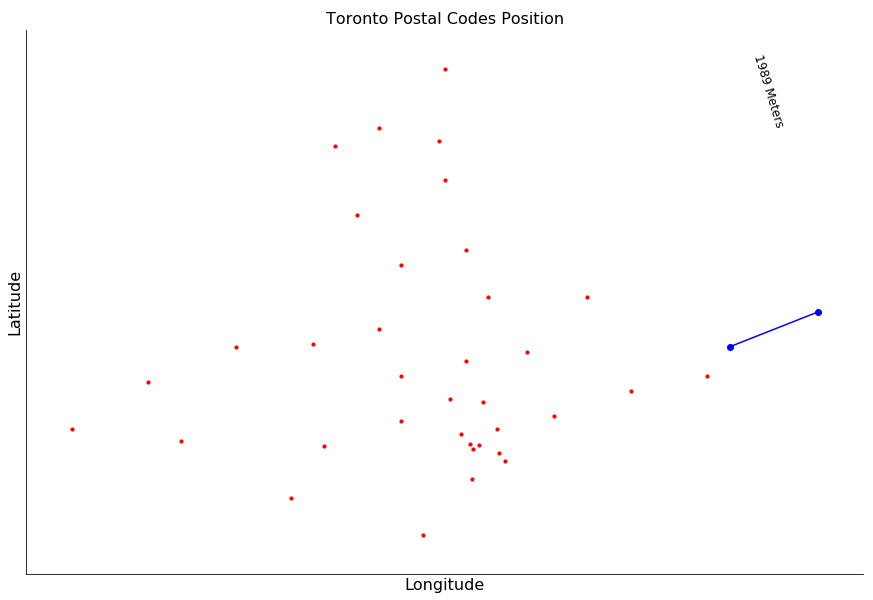

In [24]:
fig = plt.figure(figsize=(15,10))
scatter_plot = fig.add_subplot(111)
scatter_plot.scatter(X['Longitude'],X['Latitude'], s=10, c='r', marker="o")
scatter_plot.plot(close_points['Longitude'], close_points['Latitude'], c='b', marker="o")

# plt.legend(loc='upper left');
scatter_plot.annotate('{} Meters'.format(distance),
            xy=(.859, .912), xycoords='figure fraction',
            ha='left', va='top', rotation=-73,
            fontsize=12)

scatter_plot.set_yticklabels([])
scatter_plot.set_xticklabels([])
scatter_plot.set_xticks([])
scatter_plot.set_yticks([])
scatter_plot.spines['top'].set_color(None)
scatter_plot.spines['right'].set_color(None)

plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title('Toronto Postal Codes Position', fontsize=16)

scatter_plot.set_yticklabels(labels = 'Latitude', fontdict={'fontsize': 20})
plt.show()

In [25]:
from math import isnan

for lat, lng, idx in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data.index):
    distance, closest_point_index = closest_postcode([lat,lng], coordinates[~coordinates.index.isin([idx])])
    toronto_data.at[idx,'Distance'] = np.int64(distance//2) #use the half of the disstance to avoid overlapping
    
toronto_data.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Distance
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,994.0
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,896.0
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,423.0
3,M4M,East Toronto,Studio District,43.659526,-79.340923,799.0
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,851.0


In [26]:
#Neighborhood clustering
map = folium.Map(location=[43.6532,-79.3832], zoom_start=11)

for location in toronto_data.itertuples(): #iterate each row of the dataframe
    label = 'Postal Code: {};  Borough: {};  Neighborhoods: {}'.format(location[1], location[2], location[3])
    label = folium.Popup(label, parse_html=True)    
    folium.CircleMarker(
        [location[-3], location[-2]],
        radius=2,
        color='red',
        fill=True,
        fill_color='orange',
        fill_opacity=0.7,
        parse_html=False).add_to(map) 
    folium.Circle(
        radius=location[-1],
        popup=label,
        location=[location[-3], location[-2]],
        color='orange',
        fill=True,
        fill_color='orange'
    ).add_to(map) 
    
map